<a href="https://colab.research.google.com/github/IzzulGod/Sorachio-1B-Chat/blob/main/data_curation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kurasi Part 1

In [ ]:
!pip install transformers datasets --quiet

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import json
import re

input_txt = "/content/data_final.txt"
output_jsonl = "/content/train.jsonl"

with open(input_txt, "r", encoding="utf-8") as f:
    blocks = f.read().split("\n\n---\n\n")

def block_to_messages(block):
    lines = block.strip().splitlines()
    messages = []
    current_role = None
    current_content = []

    for line in lines:
        line = line.rstrip()
        if line.startswith("User:"):

            if current_role and current_content:
                messages.append({
                    "role": current_role,
                    "content": "\n".join(current_content).strip()
                })
                current_content = []
            current_role = "user"
            current_content.append(line[len("User:"):].strip())
        elif line.startswith("Sorachio:"):
            if current_role and current_content:
                messages.append({
                    "role": current_role,
                    "content": "\n".join(current_content).strip()
                })
                current_content = []
            current_role = "assistant"
            current_content.append(line[len("Sorachio:"):].strip())
        else:
            current_content.append(line)

    if current_role and current_content:
        messages.append({
            "role": current_role,
            "content": "\n".join(current_content).strip()
        })

    return messages

with open(output_jsonl, "w", encoding="utf-8") as fout:
    for block in blocks:
        messages = block_to_messages(block)
        if len(messages) >= 2:
            fout.write(json.dumps({"messages": messages}, ensure_ascii=False) + "\n")


In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-it")

dataset = load_dataset("json", data_files="/content/train.jsonl")["train"]

def tokenize(example):
    chat_str = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,
        add_generation_prompt=True
    )

    tokens = tokenizer(
        chat_str,
        truncation=True,
        max_length=4096,
    )
    return {"input_ids": tokens["input_ids"], "attention_mask": tokens["attention_mask"]}

tokenized_dataset = dataset.map(tokenize, remove_columns=dataset.column_names)

total_tokens = sum(len(x["input_ids"]) for x in tokenized_dataset)

print(f"Total jumlah token dari seluruh data: {total_tokens}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

Total jumlah token dari seluruh data: 461660


In [ ]:
def check_role_pattern(messages):
    if not messages:
        return False
    if messages[0]["role"] != "user":
        return False
    last_role = None
    for msg in messages:
        role = msg["role"]
        if role not in ["user", "assistant"]:
            return False
        if role == last_role:
            return False
        last_role = role
    return True

error_indices = []

for i, example in enumerate(dataset):
    if not check_role_pattern(example["messages"]):
        error_indices.append(i)

print(f"Jumlah data yang pola role-nya tidak valid: {len(error_indices)}")
print(f"Contoh indeks data error: {error_indices[:10]}")


Jumlah data yang pola role-nya tidak valid: 0
Contoh indeks data error: []


Has chat_template? True

Total panjang row: 1221
Row melebihi 2048 token: 1
Contoh row terlalu panjang:
- Row ke-16: 2068 tokens


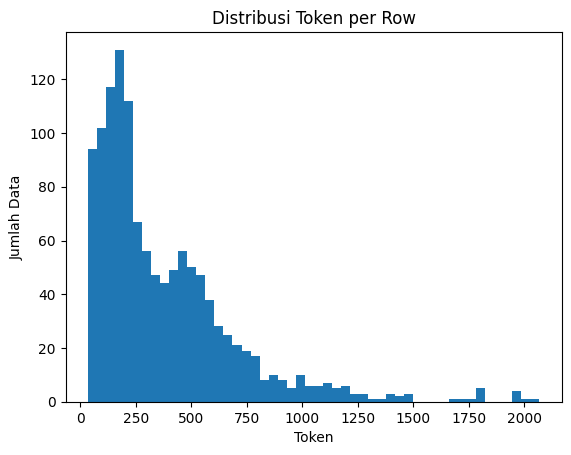

In [ ]:
from transformers import AutoTokenizer
import json

model_id = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

print("Has chat_template?", hasattr(tokenizer, "chat_template"))

MAX_TOKENS = 2048
path = "/content/train.jsonl"

long_rows = []
lengths = []

with open(path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        try:
            data = json.loads(line)
            messages = data.get("messages", [])
            if not messages:
                continue

            prompt = tokenizer.apply_chat_template(
                messages, tokenize=True, add_generation_prompt=True
            )

            token_len = len(prompt)
            lengths.append(token_len)

            if token_len > MAX_TOKENS:
                long_rows.append((i, token_len))

        except Exception as e:
            print(f"Error parsing line {i}: {e}")

print(f"\nTotal panjang row: {len(lengths)}")
print(f"Row melebihi {MAX_TOKENS} token: {len(long_rows)}")
print("Contoh row terlalu panjang:")
for row in long_rows[:10]:
    print(f"- Row ke-{row[0]}: {row[1]} tokens")

import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.title("Distribusi Token per Row")
plt.xlabel("Token")
plt.ylabel("Jumlah Data")
plt.show()


# Kurasi part 2

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#@title Install libs (Transformers terbaru + util)
!pip -q install -U "transformers>=4.43.0" datasets tqdm

import json, os, math
from pathlib import Path
from typing import List, Dict, Tuple
from tqdm.auto import tqdm

from transformers import AutoTokenizer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 109.0 MB/s eta 0:00:00


In [ ]:
#@title Path & parameter
INPUT_JSONL = "/content/train.jsonl"  #@param {type:"string"}
OUT_OK_JSONL = "/content/data_within_2048.jsonl"  #@param {type:"string"}
OUT_LONG_JSONL = "/content/data_over_2048.jsonl"  #@param {type:"string"}

# Batas konteks (token) sesuai kebutuhanmu
MAX_TOKENS = 2048  #@param {type:"integer"}

# Ganti sesuai tokenizer yang kamu pakai
MODEL_ID = "google/gemma-3-1b-it"  #@param {type:"string"}

# Pastikan file input ada
assert Path(INPUT_JSONL).exists(), f"File tidak ditemukan: {INPUT_JSONL}"
print("Config OK ✅")


Config OK ✅


In [ ]:
#@title Load tokenizer Gemma 3 + helpers
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    use_fast=True,
    trust_remote_code=True
)

def count_tokens_with_template(messages: List[Dict]) -> int:
    """
    Hitung token menggunakan chat template tokenizer.
    `messages` format: [{"role":"user","content":"..."}, {"role":"assistant","content":"..."} ...]
    """
    try:
        # tokenize=True -> return list of token ids
        ids = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=False
        )
        return len(ids)
    except Exception as e:
        # Fallback sederhana bila template tak tersedia (hasil bisa beda dari training!)
        text = []
        for m in messages:
            r = m.get("role", "user")
            c = m.get("content", "")
            text.append(f"{r.upper()}: {c}")
        ids = tokenizer("\n\n".join(text)).input_ids
        return len(ids)

def save_jsonl(path: str, rows: List[Dict]):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Tokenizer ready ✅")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Tokenizer ready ✅


In [ ]:
#@title Cek distribusi token per row (tanpa menulis file)
lengths = []
total = 0

with open(INPUT_JSONL, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Scanning"):
        line = line.strip()
        if not line:
            continue
        obj = json.loads(line)
        msgs = obj.get("messages", [])
        if not msgs:
            continue
        n_tok = count_tokens_with_template(msgs)
        lengths.append(n_tok)
        total += 1

over = sum(1 for x in lengths if x > MAX_TOKENS)
print(f"Total rows: {total}")
print(f"> {MAX_TOKENS} tokens: {over} rows ({over/total*100:.2f}%)")
print(f"Min/Avg/P90/P95/Max: {min(lengths)} / {sum(lengths)//max(1,total)} / "
      f"{sorted(lengths)[int(0.90*max(0,total)-1)] if total else '-'} / "
      f"{sorted(lengths)[int(0.95*max(0,total)-1)] if total else '-'} / "
      f"{max(lengths) if lengths else '-'}")


Scanning: 0it [00:00, ?it/s]

Total rows: 1217
> 2048 tokens: 16 rows (1.31%)
Min/Avg/P90/P95/Max: 33 / 391 / 761 / 1046 / 3763


In [ ]:
#@title Tulis dua file: dalam batas & overflow
ok_rows = []
long_rows = []

with open(INPUT_JSONL, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Splitting"):
        line = line.strip()
        if not line:
            continue
        obj = json.loads(line)
        msgs = obj.get("messages", [])
        if not msgs:
            continue
        n_tok = count_tokens_with_template(msgs)
        if n_tok <= MAX_TOKENS:
            ok_rows.append(obj)
        else:
            long_rows.append({
                **{k:v for k,v in obj.items() if k != "messages"},
                "messages": msgs,
                "_token_length": n_tok  # biar gampang review
            })

save_jsonl(OUT_OK_JSONL, ok_rows)
save_jsonl(OUT_LONG_JSONL, long_rows)

print(f"✅ Saved within-limit rows: {len(ok_rows)} -> {OUT_OK_JSONL}")
print(f"✅ Saved over-limit rows:   {len(long_rows)} -> {OUT_LONG_JSONL}")


Splitting: 0it [00:00, ?it/s]

✅ Saved within-limit rows: 1201 -> /content/data_within_2048.jsonl
✅ Saved over-limit rows:   16 -> /content/data_over_2048.jsonl


# Kurasi Part 3 (Finishing)

In [ ]:
#@title Install lib & import
!pip -q install tqdm

import json
from pathlib import Path
from tqdm.auto import tqdm


In [ ]:
import json

INPUT_JSONL = "/content/data_over_2048.jsonl"   # file input jsonl
OUTPUT_TXT = "/content/data_text_FINAL.txt" # hasil output txt

with open(INPUT_JSONL, "r", encoding="utf-8") as f, open(OUTPUT_TXT, "w", encoding="utf-8") as out:
    for line in f:
        if not line.strip():
            continue
        obj = json.loads(line)
        msgs = obj.get("messages", [])

        # tulis semua turn sesuai urutan
        for m in msgs:
            role = m.get("role")
            text = m.get("content", "").strip()

            if role == "user":
                out.write(f"User: {text}\n")
            elif role == "assistant":
                out.write(f"Sorachio: {text}\n")
            else:
                out.write(f"[{role.capitalize()}]: {text}\n")

        # setelah selesai 1 percakapan
        out.write("---\n")
